In [1]:
import ml
reload(ml)
from ml import *
import json
import timeit
import numba
import scipy
import swifter
import operator
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.ensemble import VotingClassifier
# from sklearn import linearmodel
from __future__ import division
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

In [2]:
# Import features
with open("../Data/features.txt") as file:
    features = json.load(file)
# Initialize Standard Scaler
scaler = StandardScaler() 
# Initialize Feature Values
feature_values = {}
# Import Data
data = pd.read_csv("../Data/prosper_final.csv")
data.head()

,ListingKey,FirstBidCreationDate,LastBidCreationDate,NoBids,AmountRequested,AvgInterBidTime,Gini,CV,DebtToIncomeRatio,DescriptionLength,...,ProsperRating,Friend_Count,Endorsement_Count,Role_Count,Group_Count,Watching,MemberCreationDate,TimeToFirstBid,TimeBetweenFirstLastBid,BorrowerAge
0,00033425227988088FA6752,2008-06-21 22:38:29,2008-06-23 06:08:09,15,1000.000,3101.733,0.167,0.352,0.190,190,...,0,1,1,3,3,3,2008-06-12 16:44:38,188.717,449.667,9
1,7B343428727859426204CF7,2008-08-05 19:49:08,2008-08-09 13:22:12,14,2200.000,22880.643,0.539,1.515,0.190,383,...,0,1,1,3,3,3,2008-06-12 16:44:38,75.767,1053.067,54
2,000433785890431972B4743,2007-01-03 09:11:14,2007-01-05 14:05:06,30,2550.000,8520.767,0.298,0.686,0.100,577,...,0,1,0,1,3,3,2006-05-10 16:13:00,1180.600,293.867,236
3,00083422661625108817246,2008-06-05 22:22:35,2008-06-12 22:03:28,141,3500.000,10633.589,0.198,0.608,0.350,210,...,0,1,0,1,3,3,2008-05-26 10:52:14,636.233,1420.883,0
4,000A34209897973969CFA81,2008-05-09 17:31:57,2008-05-15 15:17:26,2,1500.000,47348.000,0.468,0.935,0.040,134,...,0,1,0,2,3,3,2008-05-07 11:04:48,138.267,1305.483,1


In [5]:
data = data.sort_values(by="LastBidCreationDate")

In [6]:
data.columns

Index([u'ListingKey', u'FirstBidCreationDate', u'LastBidCreationDate',
       u'NoBids', u'AmountRequested', u'AvgInterBidTime', u'Gini', u'CV',
       u'DebtToIncomeRatio', u'DescriptionLength', u'RepaidOrNot',
       u'ListingCreationDate', u'ListingStartDate', u'MemberKey', u'Category',
       u'BidMaximumRate', u'BidCount', u'ProsperPrincipalBorrowed',
       u'ProsperPrincipalOutstanding', u'Duration', u'Images',
       u'IsBorrowerHomeowner', u'ActiveProsperLoans', u'BorrowerRate',
       u'BorrowerMaximumRate', u'TotalProsperLoans', u'ProsperScore',
       u'GroupLeaderRewardRate', u'EffectiveYield', u'FundingOption',
       u'EstimatedReturn', u'EstimatedLoss', u'MonthlyLoanPayment',
       u'OnTimeProsperPayments', u'ProsperPaymentsLessThanOneMonthLate',
       u'ProsperPaymentsOneMonthPlusLate', u'TotalProsperPaymentsBilled',
       u'BankDraftFeeAnnualRate', u'CreditScoreRange', u'NumImages',
       u'LenderYieldRate', u'LenderAvgWinningBids', u'LenderAvgTotalBids',
       u

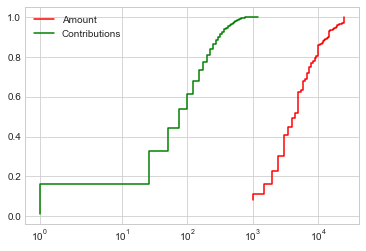

In [48]:
from statsmodels.distributions.empirical_distribution import ECDF

sample = data.AmountRequested.values
ecdf = ECDF(sample)
x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.step(x, y, c='r', label="Amount")

sample = data.BidCount.values
ecdf = ECDF(sample)
x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.step(x, y, c='g', label="Contributions")

# sample = data.Endorsement_Count.values
# ecdf = ECDF(sample)
# x = np.linspace(min(sample), max(sample))
# y = ecdf(x)
# plt.step(x, y, c='b', label="Prosper Rating")

plt.xscale("symlog")
plt.legend(loc="best?")

plt.show()

In [34]:
stats.pearsonr(data.CreditGrade.fillna(-1), 
               data.BorrowerRate.fillna(-1))

(-0.6988672929150515, 0.0)

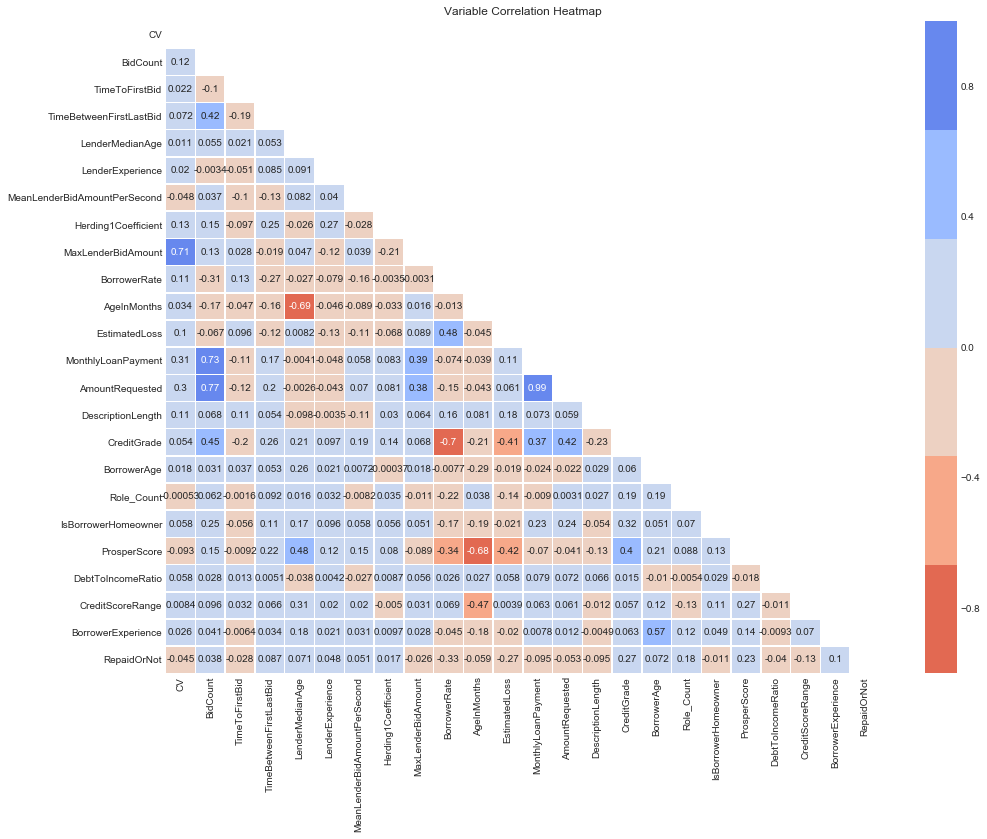

In [7]:
corr = data[features.get("All")+["RepaidOrNot"]].fillna(-1).corr(method='pearson')
corr.to_csv("../Data/corr_matrix.csv")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16,12))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        vmin = -1,
        vmax= 1,
        linewidths=.5,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

In [15]:
variables = ["BorrowerRate", 'MonthlyLoanPayment', 'EstimatedLoss', 'CreditGrade', 'AmountRequested', 
             'ProsperScore', "DebtToIncomeRatio", "CreditScoreRange", "IsBorrowerHomeowner"]
low = data[data["DebtToIncomeRatio"] <= 0.120]
medium = data[(data["DebtToIncomeRatio"] > 0.120) & (data["DebtToIncomeRatio"] < 0.30)] 
high = data[data["DebtToIncomeRatio"] >= 0.30]
frames = [low, medium, high]
names = ["low", "medium", "high"]

https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

In [32]:
for var in variables:
    model = classifiers.get("LR")
    if var == "CreditGrade":
        frame = frame[frame["CreditGrade"] < 9]
    else:
        frame = data
    X = frame[var].fillna(0)
    X = scaler.fit_transform(X.values.reshape(-1,1))
    y = frame.RepaidOrNot.values.reshape(-1,1)
    model.fit(X,y)
    #### Get p-values for the fitted model ####
    denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stats.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
    print var, np.exp(model.coef_)[0][0], p_values[0]

BorrowerRate 0.46043849437616136 0.0
MonthlyLoanPayment 0.8258242720559 1.4065419399701688e-48
EstimatedLoss 0.5447666301926295 0.0
CreditGrade 1.7913986632712335 0.0
AmountRequested 0.9003315486900472 8.461608290507509e-17
ProsperScore 1.7435973319445697 0.0
DebtToIncomeRatio 0.9192013296344761 1.0091921773805786e-08
CreditScoreRange 0.7569799897823061 1.2656868116519747e-119
IsBorrowerHomeowner 0.977855176809592 0.06684101879489768


In [31]:
for var in variables:
    for frame, name in zip(frames, names):
        model = classifiers.get("LR")
        if var == "CreditGrade":
            frame = frame[frame["CreditGrade"] < 9]
        else:
            frame = frame
        X = frame[var].fillna(0)
        X = scaler.fit_transform(X.values.reshape(-1,1))
        y = frame.RepaidOrNot.values.reshape(-1,1)
        model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stats.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        print var, name, np.exp(model.coef_)[0][0], p_values[0]

BorrowerRate low 0.3398964310161627 2.2310586680725558e-278
BorrowerRate medium 0.502579913919482 2.559224220149132e-261
BorrowerRate high 0.5522071025098947 6.103971000086297e-100
MonthlyLoanPayment low 0.9275031435278385 0.0020478095115347363
MonthlyLoanPayment medium 0.8516428576198569 1.4374029101284463e-18
MonthlyLoanPayment high 0.7941564712966166 1.4523749936226096e-17
EstimatedLoss low 0.4758918636704063 4.4991404427280046e-135
EstimatedLoss medium 0.5616144922120074 8.777253849323086e-182
EstimatedLoss high 0.5987549864866784 1.4806006387834285e-72
CreditGrade low 2.7298715363211126 3.8894994444991924e-277
CreditGrade medium 1.6623048337962545 1.147549293105725e-170
CreditGrade high 1.4528687233926854 4.1700222995881826e-48
AmountRequested low 1.0447172450808113 0.06327538025574236
AmountRequested medium 0.9281400023364543 2.5356851336547532e-05
AmountRequested high 0.8525463280481957 1.3439284295647733e-09
ProsperScore low 2.1583189088068964 3.1583795212447964e-192
ProsperSco

In [46]:
for frame, name in zip(frames, names):
    var = "IsBorrowerHomeowner"
    outcomes = [0,1]
    counts = []
    for outcome in outcomes:
        counts.append(len(frame[frame.IsBorrowerHomeowner == outcome]))
        print name, var, outcome, (Counter(frame[frame.IsBorrowerHomeowner == outcome]['RepaidOrNot'])[1] / len(frame[frame.IsBorrowerHomeowner == outcome]['RepaidOrNot']))*100

low IsBorrowerHomeowner 0 63.0048465267
low IsBorrowerHomeowner 1 72.7673649394
medium IsBorrowerHomeowner 0 64.3910716617
medium IsBorrowerHomeowner 1 63.7787723785
high IsBorrowerHomeowner 0 60.7011070111
high IsBorrowerHomeowner 1 53.8246789503


## Model Evaluation

### Ceyhan 

This time the data set was filtered to contain only the listings that got funded. Since some of the loans were still ongoing, i.e., their repayment was not over, we only picked the ones that were paid-back or defaulted. We ran logistic regression for different attribute sets. In addition to shape parameters, adding the following features of a listing gave the best results; borrower rate br, total amount requested T and whether there has been competition or not c.

When we tested our model through cross validation, the prediction accuracy was 70% this time. On the other hand, using only the shape parameters, and q, gave 67% accuracy. If we add some standard features to the model such as Prosper rate, debt-to-income ratio dr , whether or not borrower is a home owner h and listing description length dl, the accuracy only increases to <b>72%</b> from 70%.

## Borrower Features

In [5]:
X = data[list(set(features.get("Borrower"))-set(["ProsperScore", "CreditScoreRange", "DebtToIncomeRatio"]))].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
print features.get("Borrower")
evaluation = evaluation_summary(X,y)
feature_values["Borrower"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

[u'BorrowerAge', u'Role_Count', u'IsBorrowerHomeowner', u'ProsperScore', u'DebtToIncomeRatio', u'CreditScoreRange', u'BorrowerExperience']
Completed QDA in 0.1058484 seconds
Completed CART in 0.1656779 seconds
Completed GNB in 0.0823492 seconds
Completed RF in 35.6804072 seconds
Completed LR in 0.1679513 seconds
Completed ADB in 2.7213506 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.564,0.729,0.493,0.588,0.589
1,CART,0.616,0.657,0.821,0.730,0.543
2,GNB,0.562,0.724,0.496,0.589,0.586
3,RF,0.497,0.776,0.286,0.418,0.572
4,LR,0.436,0.829,0.134,0.231,0.543
5,ADB,0.645,0.655,0.925,0.767,0.545


In [6]:
X = data[list(set(features.get("All"))-set(["ProsperScore", "CreditScoreRange", "DebtToIncomeRatio"]))].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
# print features.get("Borrower")
evaluation = evaluation_summary(X,y)
feature_values["Borrower"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

Completed QDA in 0.3897218 seconds
Completed CART in 2.2598869 seconds
Completed GNB in 0.1746303 seconds
Completed RF in 124.7634843 seconds
Completed LR in 1.5557941 seconds
Completed ADB in 10.1181466 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.677,0.785,0.673,0.724,0.678
1,CART,0.629,0.709,0.699,0.704,0.603
2,GNB,0.663,0.768,0.668,0.714,0.661
3,RF,0.695,0.790,0.704,0.745,0.691
4,LR,0.613,0.863,0.460,0.600,0.667
5,ADB,0.711,0.740,0.836,0.785,0.666


In [7]:
X = data[features.get("Borrower")].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
print features.get("Borrower")
evaluation = evaluation_summary(X,y)
feature_values["Borrower"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

[u'BorrowerAge', u'Role_Count', u'IsBorrowerHomeowner', u'ProsperScore', u'DebtToIncomeRatio', u'CreditScoreRange', u'BorrowerExperience']
Completed QDA in 0.1400856 seconds
Completed CART in 0.3536039 seconds
Completed GNB in 0.1105949 seconds
Completed RF in 39.3422893 seconds
Completed LR in 0.3039003 seconds
Completed ADB in 3.185946 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.677,0.738,0.759,0.748,0.648
1,CART,0.621,0.706,0.687,0.696,0.598
2,GNB,0.652,0.742,0.689,0.715,0.639
3,RF,0.627,0.786,0.563,0.656,0.650
4,LR,0.552,0.845,0.355,0.500,0.622
5,ADB,0.698,0.724,0.845,0.779,0.646


In [8]:
frank_summary(X, y, features.get("Borrower"))

Feature ranking completed in 16.848484 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,DebtToIncomeRatio,1,True,0.284,5
1,ProsperScore,1,True,0.263,4
2,BorrowerAge,1,True,0.250,1
3,Role_Count,1,True,0.070,2
4,BorrowerExperience,1,True,0.057,7
5,CreditScoreRange,1,True,0.056,6
6,IsBorrowerHomeowner,1,True,0.020,3


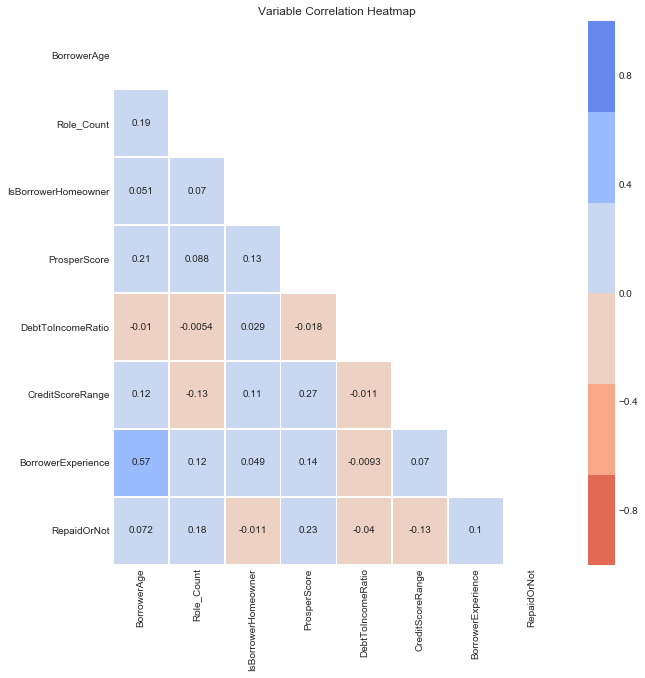

In [9]:
corr = data[features.get("Borrower")+["RepaidOrNot"]].fillna(-1).corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        vmin = -1,
        vmax= 1,
        linewidths=.5,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

## Lender Features

In [10]:
X = data[features.get("Lender")].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
print features.get("Lender")
evaluation = evaluation_summary(X,y)
feature_values["Lender"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

[u'CV', u'BidCount', u'TimeToFirstBid', u'TimeBetweenFirstLastBid', u'LenderMedianAge', u'LenderExperience', u'MeanLenderBidAmountPerSecond', u'Herding1Coefficient', u'MaxLenderBidAmount']
Completed QDA in 0.1411734 seconds
Completed CART in 1.9982659 seconds
Completed GNB in 0.1414852 seconds
Completed RF in 147.2135783 seconds
Completed LR in 0.3755505 seconds
Completed ADB in 7.6728209 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.619,0.641,0.901,0.749,0.518
1,CART,0.567,0.659,0.650,0.655,0.537
2,GNB,0.619,0.642,0.898,0.749,0.519
3,RF,0.600,0.710,0.620,0.662,0.593
4,LR,0.385,0.832,0.034,0.065,0.511
5,ADB,0.634,0.657,0.883,0.753,0.546


In [11]:
frank_summary(X, y, features.get("Lender"))

Feature ranking completed in 71.0284231 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,LenderExperience,1,True,0.153,6
1,TimeBetweenFirstLastBid,1,True,0.127,4
2,MeanLenderBidAmountPerSecond,1,True,0.119,7
3,LenderMedianAge,1,True,0.118,5
4,TimeToFirstBid,1,True,0.109,3
5,CV,1,True,0.107,1
6,Herding1Coefficient,1,True,0.105,8
7,BidCount,1,True,0.102,2
8,MaxLenderBidAmount,1,True,0.060,9


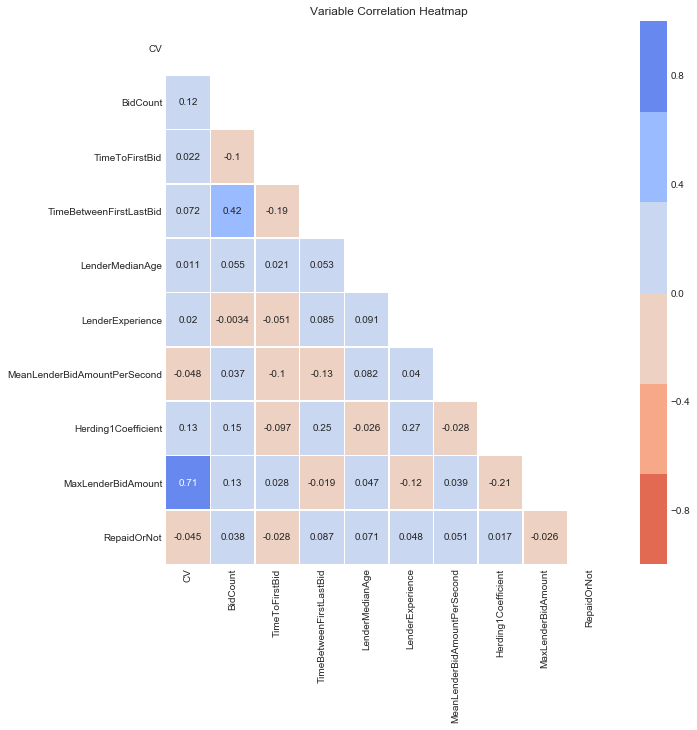

In [12]:
corr = data[features.get("Lender")+["RepaidOrNot"]].fillna(-1).corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        vmin = -1,
        vmax= 1,
        linewidths=.5,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

## Loan Features

In [13]:
X = data[features.get("Loan")].fillna(-1)
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
print features.get("Loan")
evaluation = evaluation_summary(X,y)
feature_values["Loan"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

[u'BorrowerRate', u'AgeInMonths', u'EstimatedLoss', u'MonthlyLoanPayment', u'AmountRequested', u'DescriptionLength', u'CreditGrade']
Completed QDA in 0.1083438 seconds
Completed CART in 0.6444249 seconds
Completed GNB in 0.0924503 seconds
Completed RF in 59.4492832 seconds
Completed LR in 0.4106425 seconds
Completed ADB in 4.2017741 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.694,0.749,0.775,0.762,0.664
1,CART,0.623,0.704,0.695,0.700,0.597
2,GNB,0.678,0.731,0.777,0.753,0.643
3,RF,0.660,0.794,0.624,0.699,0.673
4,LR,0.595,0.848,0.437,0.577,0.651
5,ADB,0.697,0.727,0.832,0.776,0.648


In [14]:
frank_summary(X, y, features.get("Loan"))

Feature ranking completed in 26.640859 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,BorrowerRate,1,True,0.263,1
1,MonthlyLoanPayment,1,True,0.193,4
2,DescriptionLength,1,True,0.161,6
3,EstimatedLoss,1,True,0.109,3
4,AgeInMonths,1,True,0.102,2
5,AmountRequested,1,True,0.100,5
6,CreditGrade,1,True,0.072,7


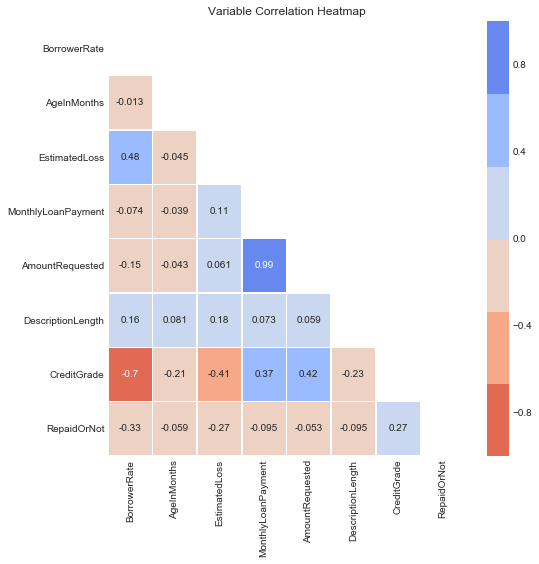

In [15]:
corr = data[features.get("Loan")+["RepaidOrNot"]].fillna(-1).corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        vmin = -1,
        vmax= 1,
        linewidths=.5,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

# Feature Permutation

## Lender + Borrower Features

In [16]:
X = data[features.get("Lender")+features.get("Borrower")].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
evaluation = evaluation_summary(X,y)
feature_values["Lender + Borrower"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

Completed QDA in 0.1965528 seconds
Completed CART in 1.7413947 seconds
Completed GNB in 0.1362856 seconds
Completed RF in 115.1919532 seconds
Completed LR in 0.7583366 seconds
Completed ADB in 9.6212874 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.666,0.738,0.730,0.734,0.643
1,CART,0.621,0.702,0.694,0.698,0.595
2,GNB,0.647,0.744,0.671,0.706,0.638
3,RF,0.689,0.777,0.713,0.743,0.681
4,LR,0.556,0.841,0.367,0.511,0.624
5,ADB,0.699,0.727,0.838,0.778,0.649


## Lender + Loan Features

In [17]:
X = data[features.get("Lender")+features.get("Loan")].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
evaluation = evaluation_summary(X,y)
feature_values["Lender + Loan"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

Completed QDA in 0.2519844 seconds
Completed CART in 2.3177694 seconds
Completed GNB in 0.1980621 seconds
Completed RF in 153.8908647 seconds
Completed LR in 1.3362955 seconds
Completed ADB in 11.3811394 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.686,0.751,0.750,0.751,0.662
1,CART,0.613,0.695,0.690,0.693,0.586
2,GNB,0.670,0.736,0.745,0.740,0.643
3,RF,0.683,0.779,0.697,0.736,0.679
4,LR,0.592,0.846,0.433,0.573,0.649
5,ADB,0.697,0.726,0.837,0.777,0.647


## Borrower + Loan Features

In [18]:
X = data[features.get("Borrower")+features.get("Loan")].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
evaluation = evaluation_summary(X,y)
feature_values["Borrower + Loan"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

Completed QDA in 0.2580581 seconds
Completed CART in 1.3450607 seconds
Completed GNB in 0.2057921 seconds
Completed RF in 63.9921548 seconds
Completed LR in 0.959759 seconds
Completed ADB in 5.0869778 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.705,0.775,0.752,0.763,0.689
1,CART,0.649,0.725,0.715,0.720,0.625
2,GNB,0.685,0.769,0.716,0.742,0.674
3,RF,0.703,0.811,0.690,0.746,0.707
4,LR,0.621,0.863,0.475,0.613,0.673
5,ADB,0.724,0.753,0.840,0.794,0.683


## Borrower + Loan + Lender

In [19]:
(.707-.692)/.707

0.021216407355021238

In [20]:
X = data[features.get("Borrower")+features.get("Loan")+features.get("Lender")].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
evaluation = evaluation_summary(X,y)
feature_values["Borrower + Loan + Lender"] = evaluation.query("Model == 'RF'")["AUC"].item()
evaluation

Completed QDA in 0.3132316 seconds
Completed CART in 2.3194582 seconds
Completed GNB in 0.2079361 seconds
Completed RF in 116.2309154 seconds
Completed LR in 1.8966183 seconds
Completed ADB in 12.5959312 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.699,0.776,0.736,0.755,0.685
1,CART,0.643,0.722,0.709,0.715,0.620
2,GNB,0.680,0.771,0.703,0.736,0.672
3,RF,0.714,0.797,0.735,0.765,0.707
4,LR,0.620,0.861,0.476,0.613,0.672
5,ADB,0.725,0.754,0.837,0.793,0.684


In [21]:
all_features = features.get("Borrower")+features.get("Loan")+features.get("Lender")
frank_summary(X, y, all_features, output="f")

Feature ranking completed in 175.2598425 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,BorrowerRate,1,True,0.124,8
1,MonthlyLoanPayment,1,True,0.069,11
2,EstimatedLoss,1,True,0.055,10
3,ProsperScore,1,True,0.053,4
4,LenderExperience,1,True,0.052,20
5,MeanLenderBidAmountPerSecond,1,True,0.045,21
6,TimeBetweenFirstLastBid,1,True,0.045,18
7,DescriptionLength,1,True,0.045,13
8,LenderMedianAge,1,True,0.045,19
9,TimeToFirstBid,1,True,0.044,17


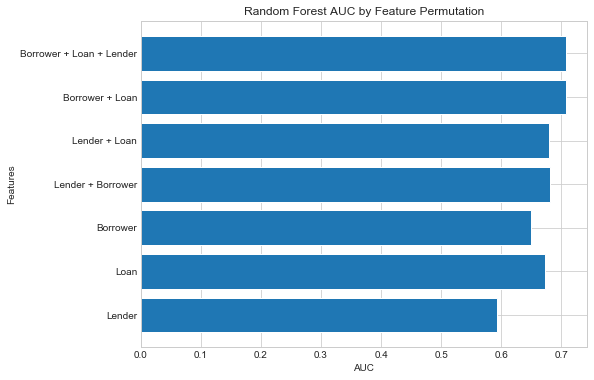

In [22]:
feature_labels  = ["Lender",
                   "Loan",
                   "Borrower",
                   "Lender + Borrower", 
                   "Lender + Loan",
                   "Borrower + Loan",
                   "Borrower + Loan + Lender"]
feature_vals = [feature_values.get(feature) for feature in feature_labels]

ind = np.arange(len(feature_vals)) 

fig, ax = plt.subplots(figsize=(8,6))
y_pos = list(reversed(np.arange(len(feature_labels))))
performance = feature_vals

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_labels)
ax.invert_yaxis()
ax.set_ylabel("Features")
ax.set_xlabel('AUC')
ax.set_title('Random Forest AUC by Feature Permutation')

plt.show()

## Models Comparison

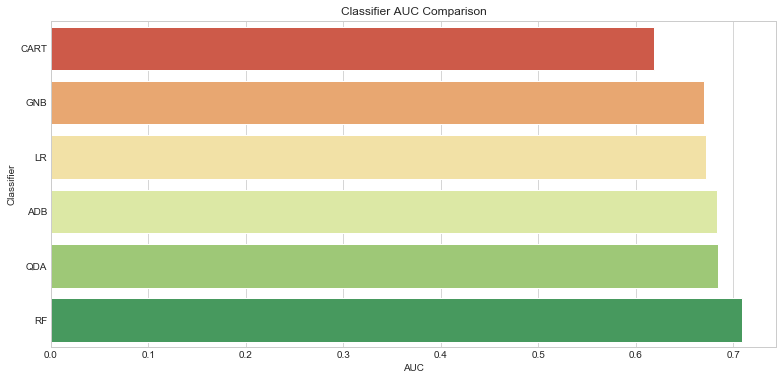

In [18]:
X = data[features.get("All")].fillna(-1)
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
plot_auc(X,y, classifiers.keys())

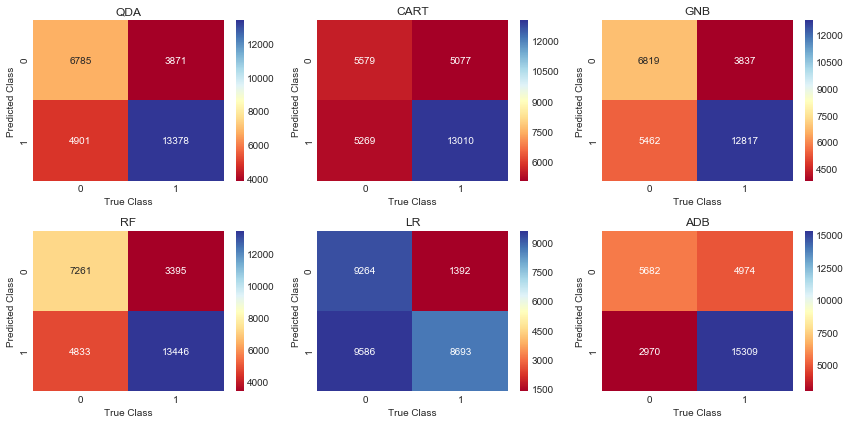

In [19]:
X = data[features.get("All")].fillna(-1)
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
plot_confusion_matrix(X,y)

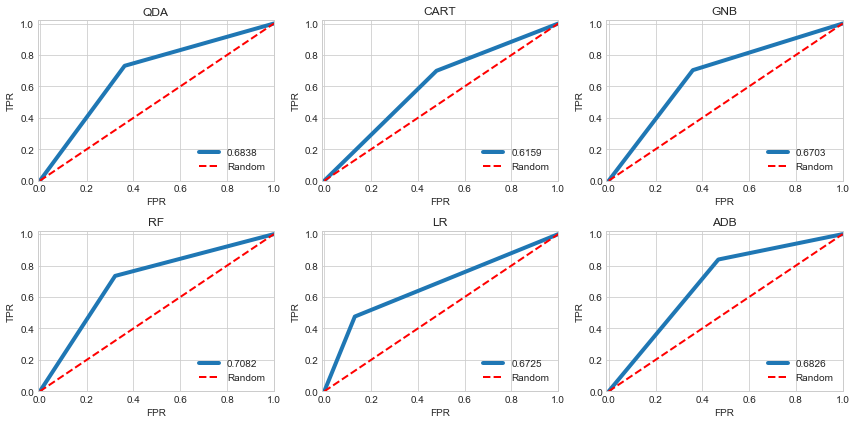

In [20]:
X = data[features.get("All")].fillna(-1)
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
plot_roc(X,y)

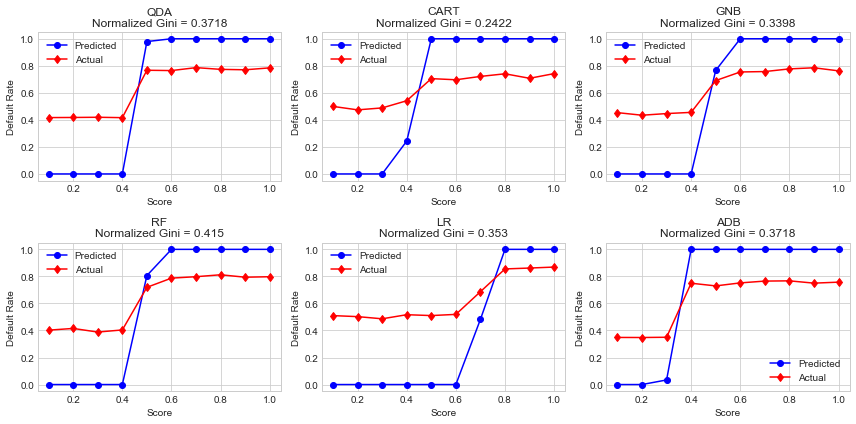

In [21]:
X = data[features.get("All")].fillna(-1)
X = scaler.fit_transform(X)
y = data['RepaidOrNot']
plot_lift(X,y)

# Ensemble Soft-Voting Classifier

In [23]:
# X = data[features.get("All")].fillna(-1)
# X = scaler.fit_transform(X)
# y = data['RepaidOrNot']

# eclf_soft = VotingClassifier(estimators=[('ADB', classifiers.get('ADB')),
#                                        ('QDA', classifiers.get('QDA')),
#                                        ('RF', classifiers.get('RF'))],
#                                voting='soft',
#                                n_jobs=-1)

# y_pred = run_cv(X,y,eclf_soft)
# print accuracy(y, y_pred), precision(y, y_pred), recall(y, y_pred), f1(y, y_pred), auc(y, y_pred)

0.7094867807153966 0.7870558818398558 0.7404672028010285 0.7630510767843048 0.6984055233224362


In [27]:
stats.pearsonr(data.BorrowerRate, data.CreditGrade)

(-0.6988672929150515, 0.0)